![](encabezado.png)

---

# **Cocientes espectrales**

---

**Objetivos**:
- Que el estudiante aprenda conceptos básicos de la sintaxis de Python, manejo de variables, vectores, matrices, funciones, etc., así como bibliotecas comunes para el análisis numérico y científico, como `Numpy` y `Matplotlib`.
- Que el alumno aprenda los elementos básicos del análisis de señales sísmicas, en específico el método H/V para determinar periodos de vibración fundamental en suelos.

---

Los cocientes espectrales es una técnica de análisis de señales sísmicas que tiene el objetivo de determinar el periodo fundamental de vibración del suelo. Se utilizan estaciones acelerográficas de tres componentes, de las cuales se obtienen los espectro de Fourier correspondientes y se genera su cociente. Se debe contar con una componente vertical y al menos una horizontal. Las componentes horizontales se promedian y se dividen entre la componente vertical (de ahí el nombre H/V), lo cual da como resultado un espectro con un pico de frecuencias coincidente con la frecuencia de vibración fundamental del suelo donde se encuentra la estación.

El método de cocientes espectrales también es llamado H/V o técnica de Nakamura (1989), por haberla distribuido entre la comunidad científica. 

---

Leer archivo de aceleración

Centro de Instrumentación y Registro Sísmico, CIRES

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
# ---------------

path = r'Sample data\AO2420170908044917'
data = np.loadtxt(path, unpack=True, skiprows=109, encoding='latin1')
N, Z, E = data

fs = 100.0
dt = 1/fs

print(data.shape)

# Se pueden ventanear todos los arreglos en una sola linea
# datas = np.r_[np.array_split(data, indices_or_sections=20, axis=-1)]
# for v in datas[:,0]:
# 	plt.plot(v)


(3, 32460)


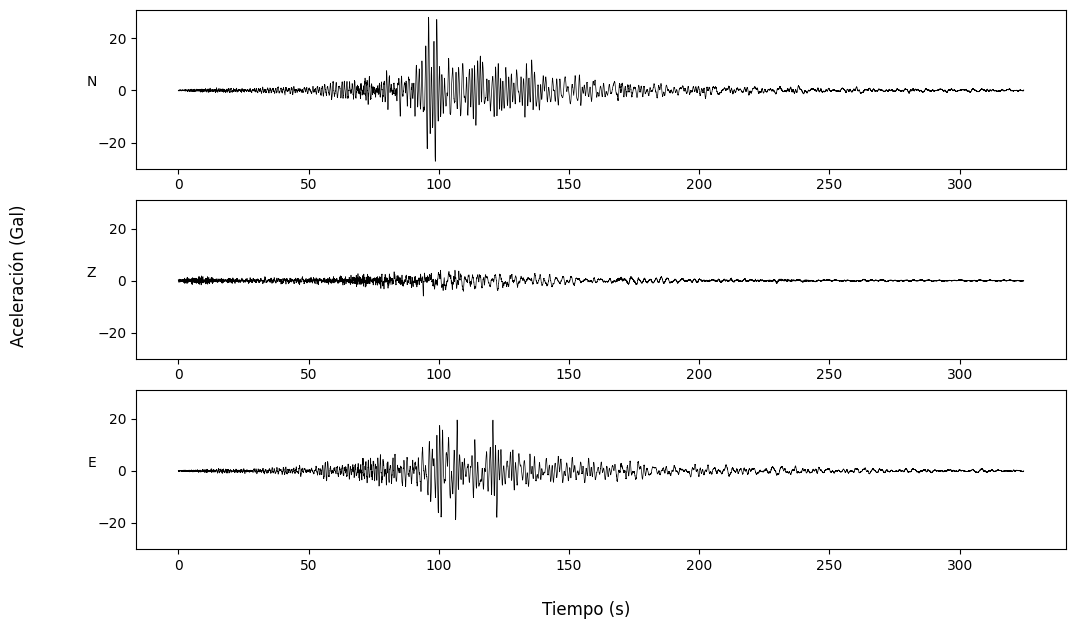

In [2]:
# Número de muestras de la señal
n = len(N)
t = np.arange(0, n*dt, dt)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharey=True)
ax = axes[0]
ax.plot(t, N, c='k', lw=0.5)
ax.set_ylabel('N', rotation=0)

ax = axes[1]
ax.plot(t, Z, c='k', lw=0.5)
ax.set_ylabel('Z', rotation=0)

ax = axes[2]
ax.plot(t, E, c='k', lw=0.5)
ax.set_ylabel('E', rotation=0)

fig.supylabel('Aceleración (Gal)')
fig.supxlabel('Tiempo (s)')
plt.show()

## Obtención de los espectros de Fourier

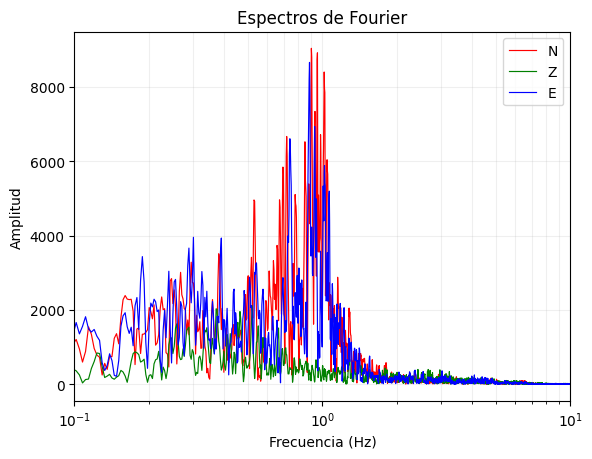

In [3]:
from numpy.fft import fft, fftshift
from scipy.signal import detrend, windows
# ------------

# Espectro de amplitud
# Se corta desde la mitad hasta el final
# O bien, se puede utilizar rfft en su lugar
cos = windows.cosine(len(N))
N_spec = fftshift(fft(detrend(N)*cos))[n//2:]
Z_spec = fftshift(fft(detrend(Z)*cos))[n//2:]
E_spec = fftshift(fft(detrend(E)*cos))[n//2:]

# Vector de frecuencias con la Frecuencia de Nyquist
# Se puede utilizar fftfreq (o rfftfreq)
fn = 1/(2*dt)
f0 = 1/(n*dt)
freq = np.arange(-fn,fn,f0)
# Corta la frecuencia de la mitad al final
freq = freq[n//2:-1]

%matplotlib inline

plt.semilogx(freq, np.abs(N_spec), c='r', label='N', lw=0.85)
plt.semilogx(freq, np.abs(Z_spec), c='g', label='Z', lw=0.85)
plt.semilogx(freq, np.abs(E_spec), c='b', label='E', lw=0.85)
plt.title("Espectros de Fourier")
plt.ylabel("Amplitud")
plt.xlabel("Frecuencia (Hz)")

plt.xlim(1e-01,10)
plt.legend()
plt.grid(ls='-', which='both', alpha=0.2)
plt.show()

## Calcular H/V con una sola ventana

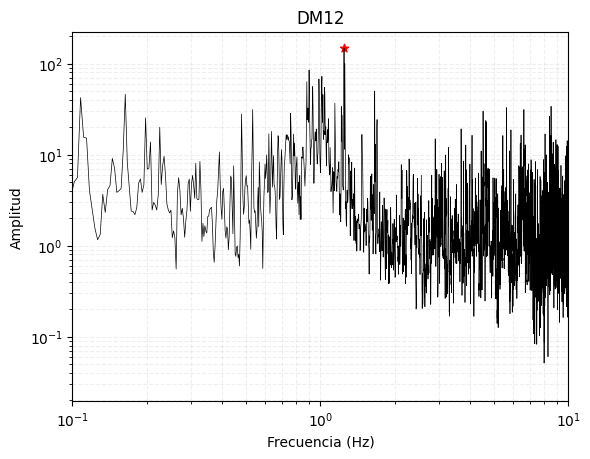

In [4]:
from scipy.signal import savgol_filter
# ---------

# Promedio cuadrático de los espectros horizontales
H = np.sqrt((E_spec)**2 + (N_spec)**2)

# Espectro H/V
HV = np.abs(H/(Z_spec))

# Espectro H/V suavizado con un filtro Savitsky-Golay de tamaño 10 con polinomio grado 3
HVf = savgol_filter(np.abs(HV), window_length=10, polyorder=3)

# Encuentra el índice del valor máximo de H/V
max_ind = np.argmax(HV)

# ---------

plt.loglog(freq, np.abs(HV), lw=0.5, c='k')
plt.scatter(freq[max_ind], np.max(HV), color='r', marker='*')
# plt.text(freq[max_ind], np.max(HV)*1.01, s=np.max(HV))
plt.title('DM12')
plt.ylabel('Amplitud')
plt.xlabel('Frecuencia (Hz)')

plt.xlim(1e-01, 1e1)
plt.grid(ls='--', which='both', alpha=0.2)
plt.show()

# H/V con varias ventanas

Se debe ventanear la señal en el dominio del tiempo primero, para después obtener el espectro de Fourier de cada ventana. Así, los vectores de frecuencia de cada ventana son comunes y se pueden graficar juntos.

Se puede optar por separar las señales por número de ventanas o por tamaño de ventana. En cualquier caso, se debe especificar la longitud de la ventana.

La función `array_split()` de `numpy` da la posibilidad de separar un vector en múltiples vectores, aunque el divisor no dé como resultado vectores de longitud igual, es decir, que el vector original no sea divisible de manera exacta. La sintaxis de esta función es:

```python
>> a = np.array([1,2,3,4,5,6,7,8,9,0])
>> new = np.array_split(ary=a,
			# si `indices_or_sections` es un entero, se asume como número de secciones
			# si es una lista, se asume como los índices en los cuales se hará la separación 
			indices_or_sections=2,
			axis=0)
>> new2 = np.array_split(ary=a,
			indices_or_sections=[2],
			axis=0)
>> print('\nNew: ', new)
>> print('\nNew2: ', new2)
New: [array([1,2,3,4,5]), 
array([6,7,8,9,0])]

New2: [array([1,2,3]),
array([4,5,6,7,8,9,0])]
```



- **Corte por número de ventanas**:

Para cortar el vector de aceleración en el dominio del tiempo mediante la cantidad de ventanas que se quieren, se utiliza un entero en `indices_or_sections`.

- **Corte por tamaño de ventana**:

Si se requiere cortarlo por tamaño de ventana, se debe utilizar la frecuencia de muestreo para realizar el cálculo.

Sabiendo que el vector tiene una cantidad de elementos `N` y una frecuencia de muestreo `fs`, se puede calcular los índices en los cuales se cortará el vector. Se toma la longitud deseada `L` en segundos (asumiendo que `fs` está en Hz) y se multiplica por `fs`, obteniendo así la cantidad de muestras que corresponden a esa longitud de tiempo

$$

muestras= L \times fs

$$

Así, para obtener los índices en los cuales se cortará el vector, se debe conocer la cantidad de ventanas de longitud `L` posibles. Para esto se calcula la división entera entre `N` y `muestras`, de tal manera que

$$

secciones = \lfloor \frac{N}{muestras} \rfloor

$$

Se calculan entonces los indices correspondientes a todas las secciones, mediante una lista, creada a través de una *list comprehension*:

``` python 
indices = [int(muestras*seccion) for seccion in range(1,secciones+1)]
```

Este valor se puede pasar a la función `np.array_split(indices_or_sections=indices)` para cortar el vector en los ínidices especificados, logrando así una lista de sub-vectores con una longitud específica. Dado que la división puede no ser exacta, se elimina el último elemento de esta lista de sub-vectores, pues puede contener una longitud distinta y generar problemas

```python
new = np.array_split(ary=a,
		indices_or_sections=indices)[:-1]
```


### Se calculan los índices y se cortan los vectores

In [5]:
from numpy.fft import rfft, rfftfreq
from scipy.signal import medfilt, windows

# Se generan los indices según la longitud deseada
## Se recomienda tomar una longitud múltiplo de 2^n
L = 30
longitud = len(N)
muestras = L*fs
secciones = int(np.floor(longitud/muestras))
print('Numero de ventanas: ', secciones)
indices = [int(muestras*seccion) for seccion in range(1, secciones+1)]

# Se cortan los vectores
N_split = np.array_split(ary=N,
						 indices_or_sections=indices)[:-1]
Z_split = np.array_split(ary=Z,
						 indices_or_sections=indices)[:-1]
E_split = np.array_split(ary=E,
						 indices_or_sections=indices)[:-1]


Numero de ventanas:  10


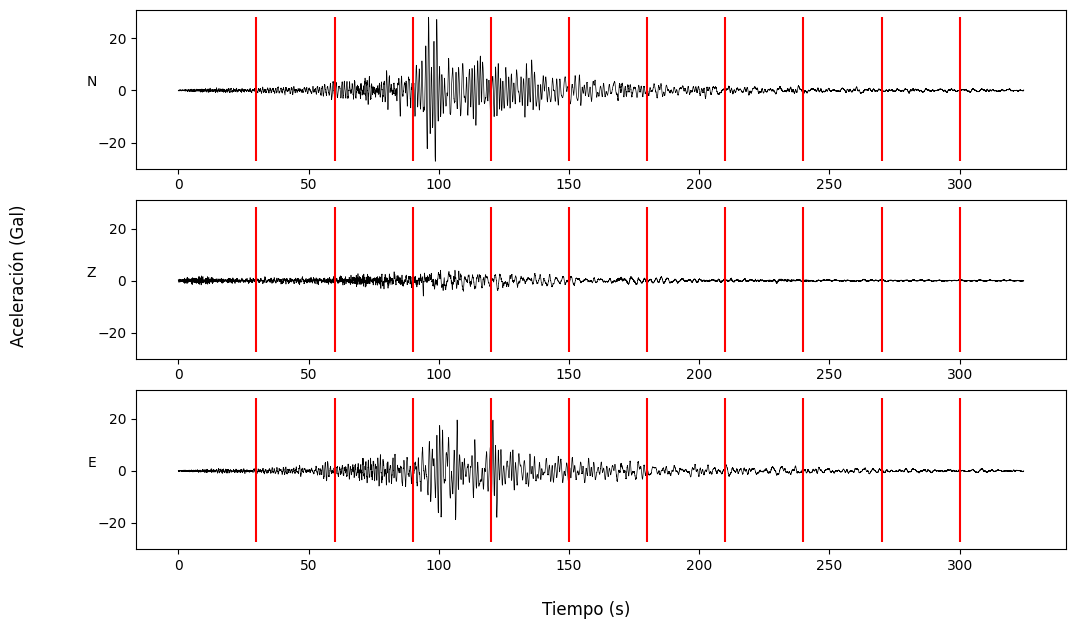

In [6]:
# Número de muestras de la señal
n = len(N)
t = np.arange(0, n*dt, dt)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharey=True)
ax = axes[0]
ax.plot(t, N, c='k', lw=0.5)
ax.set_ylabel('N', rotation=0)
ax.vlines(np.r_[indices]*(1/fs), min(N), max(N), colors='r')

ax = axes[1]
ax.plot(t, Z, c='k', lw=0.5)
ax.set_ylabel('Z', rotation=0)
ax.vlines(np.r_[indices]*(1/fs), min(N), max(N), colors='r')

ax = axes[2]
ax.plot(t, E, c='k', lw=0.5)
ax.set_ylabel('E', rotation=0)
ax.vlines(np.r_[indices]*(1/fs), min(N), max(N), colors='r')

fig.supylabel('Aceleración (Gal)')
fig.supxlabel('Tiempo (s)')
plt.show()

Se eliminan las ventanas que contengan demasiada energía en la señal, debido a que pueden introducir ruido debido al comportamiento no lineal del suelo en presencia de un movimiento fuerte.

In [7]:
N_split = np.delete(N_split, [3,4,5], axis=0)
Z_split = np.delete(Z_split, [3,4,5], axis=0)
E_split = np.delete(E_split, [3,4,5], axis=0)

### Se generan espectros de Fourier y frecuencias para cada ventana

In [8]:

# Se calculan los espectros de Fourier para cada componente
## Se crea una ventana de taper
cos = windows.cosine(len(N_split[0]))

## Componente norte
Nsplit_fft = [] 
for n in N_split:
	ft = np.abs(rfft(n*cos))
	Nsplit_fft.append(ft)
Nsplit_fft = np.array(Nsplit_fft)

## Componente vertical
Zsplit_fft = [] 
for z in Z_split:
	ft = np.abs(rfft(z*cos))
	Zsplit_fft.append(ft)
Zsplit_fft = np.array(Zsplit_fft)

## Componente este
Esplit_fft = [] 
for e in E_split:
	ft = np.abs(rfft(e*cos))
	Esplit_fft.append(ft)
Esplit_fft = np.array(Esplit_fft)

## Vector de frecuencias
freq = rfftfreq(len(Z_split[0]), d=1/fs)



### Se calcula el H/V de cada ventana

In [9]:

# Se calcula el promedio cuadrático para las componentes horizontales
Hsplit_fft = np.sqrt(Nsplit_fft**2 + Esplit_fft**2)

# Se calcula H/V para todas las ventanas
HV = Hsplit_fft / Zsplit_fft

# Se calcual el H/V promedio
HVm = np.mean(HV, axis=0)


Suavizamiento Konno-Ohmachi:

$$

W_B(f,f_c) = \left[ 
	\frac{\sin \left( 
		\log_{10} \left(
			\frac{f}{f_c}
		\right)^{b}
	\right)}
	{\log_{10}\left(
			\frac{f}{f_c}
		\right)^{b}}
	\right]^4

$$

In [10]:
# Se realiza el suavizamiento Konno-Ohmachi
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing

# normalize=True para utilizar con una escala logarítmica
HVm = konno_ohmachi_smoothing(spectra=HVm, frequencies=freq, bandwidth=40, normalize=True)

### Se generan las gráficas de los espectros H/V de todas las ventanas y su promedio

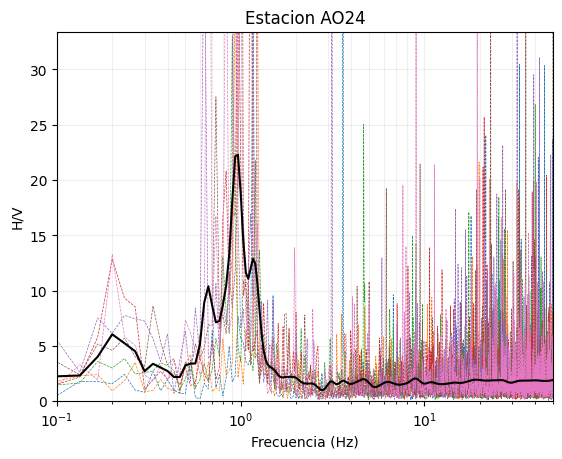

In [11]:
%matplotlib inline
for hv in HV:
	plt.semilogx(freq, hv, lw=0.5, ls='--')

plt.semilogx(freq, HVm, lw=1.5, c='k')

plt.title('Estacion AO24')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('H/V')

plt.ylim(0,np.max(HVm*1.5))
plt.xlim(0.1,50)
plt.grid(alpha=0.2, which='both')
plt.show()